In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy
import matplotlib.pyplot as plt
import os
import sys
from counterfactual_tpp import sample_counterfactual, superposition, combine, check_monotonicity, distance
from sampling_utils import homogenous_poisson, thinning, thinning_T
from multiprocessing import cpu_count, Pool
from tqdm import tqdm
import utils

In [2]:
cpu_count()

48

In [3]:
def normal(x, mean, sd, amp):  
    return amp * (1/(sd * (np.sqrt(2*np.pi)))) * np.exp(-0.5*((x-mean)/sd)**2)

# Setting the parameters of the original intensity
T = 5
number_of_gaussians = 5
np.random.seed(0)
means = np.arange(1, T , step = (T - 1) / number_of_gaussians)
means[0] = 0.55
sds = np.random.uniform(low=0, high=0.5, size=number_of_gaussians)
amps = 10 * np.random.uniform(low=1.0, high=3.0, size=number_of_gaussians)
print('means', means)
print('sds', sds)
print('amps', amps)
#**********************
def original(x):
    res = 0
    for i in range(number_of_gaussians):
        res += normal(x, means[i], sds[i], amps[i])
    return res

means [0.55 1.8  2.6  3.4  4.2 ]
sds [0.27440675 0.35759468 0.30138169 0.27244159 0.2118274 ]
amps [22.91788226 18.75174423 27.83546002 29.27325521 17.66883038]


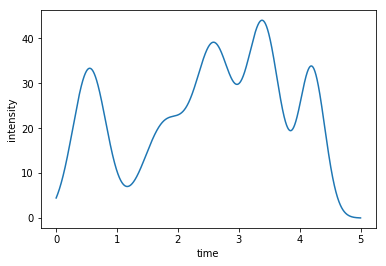

In [4]:
# plotting the original intensity
x = np.linspace(0, T, 10000)
sns.lineplot(data = pd.DataFrame({'time':x, 'intensity':original(x)}), x="time", y="intensity")

In [5]:
# intervention intensity
modified_index = np.random.choice(a = np.arange(number_of_gaussians), size = 1)[0]
print('index', modified_index)
new_amp = amps[modified_index] + np.random.normal(loc=0.0, scale=10, size=1)
print('previous amp', amps[modified_index])
print('new amp', new_amp)
new_amps = np.zeros(amps.shape)
for i in range(len(new_amps)):
    if i == modified_index:
        new_amps[i] = new_amp[0]
    else:
        new_amps[i] = amps[i]
                    
def intervention(x):
    res = 0
    for i in range(number_of_gaussians):
        res += normal(x, means[i], sds[i], new_amps[i])
    return res

index 0
previous amp 22.917882261333126
new amp [34.1710233]


In [6]:
# window_radious = (means[modified_index] - means[modified_index - 1]) / 2
# window_center = means[modified_index]

In [39]:
window_radious = (means[modified_index + 1] - means[modified_index]) / 2
window_center = means[modified_index]

In [52]:
begin = window_center - window_radious
end = window_center + window_radious
if begin < 0:
    t = 0 - begin
    begin = 0
    end = end - t
print('beginning of the interval: ', begin)
print('ending of the interval: ', end)
print('window center', window_center)

beginning of the interval:  0
ending of the interval:  1.1
window center 0.55


In [8]:
path = 'figs/new_figs/'

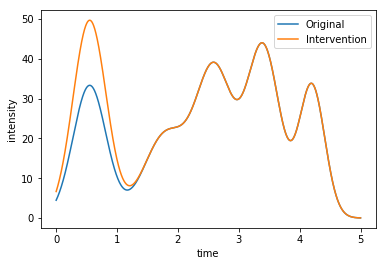

In [9]:
# Visualizing both intensities
sns.lineplot(data = pd.DataFrame({'time':x, 'intensity':original(x)}), x="time", y="intensity", label = 'Original')
sns.lineplot(data = pd.DataFrame({'time':x, 'intensity':intervention(x)}), x="time", y="intensity", label = 'Intervention')
plt.legend()

In [10]:
lambda_max = 100

In [11]:
def counterfactual(_):
    sample, indicators = thinning_T(0, intensity=original, lambda_max=lambda_max, T=T)
    lambdas = original(np.asarray(sample))
    sample = np.asarray(sample)
    counters = []
    for counter in range(100):
        counterfactuals, counterfactual_indicators = sample_counterfactual(sample, lambdas, lambda_max, indicators, intervention)
        counters.append(counterfactuals)
    return sample[indicators], counters

In [11]:
def counterfactual1(_):
    sample, indicators = thinning_T(0, intensity=original, lambda_max=lambda_max, T=T)
    lambdas = original(np.asarray(sample))
    sample = np.asarray(sample)
    counters = []
    for counter in range(100):
        counterfactuals, counterfactual_indicators = sample_counterfactual(sample, lambdas, lambda_max, indicators, intervention)
        if check_monotonicity(sample, counterfactuals, original, intervention, sample[indicators]) != 'MONOTONIC':
            print('Not monotonic')
        counters.append(counterfactuals)
    return sample[indicators], counters, sample, indicators

In [22]:
samples_load = np.load('data_inhomogeneous/allsamples.npy', allow_pickle=True)

In [23]:
import json
with open(r'data_inhomogeneous/allindicators.json', "r") as read_file:
    indicators_load = json.load(read_file)

In [35]:
f = [samples_load[i][indicators_load[i]] for i in range(1000)]

In [15]:
def counterfactual2(_):
    sample = samples_load[_]
    indicators = indicators_load[_]
    lambdas = original(sample)
    counters = []
    for counter in range(100):
        counterfactuals, counterfactual_indicators = sample_counterfactual(sample, lambdas, lambda_max, indicators, intervention)
        if check_monotonicity(sample, counterfactuals, original, intervention, sample[indicators]) != 'MONOTONIC':
            print('Not monotonic')
        counters.append(counterfactuals)
    return sample[indicators], counters

In [16]:
with Pool(48) as pool:
    result = list(tqdm(pool.imap(counterfactual2, list(range(1000))), total = 1000))

100%|███████████████████████████████████████████████████████████████████████████████| 1000/1000 [28:46<00:00,  1.73s/it]


In [13]:
# with Pool(48) as pool:
#     result = list(tqdm(pool.imap(counterfactual1, list(range(1000))), total = 1000))

100%|██████████| 1000/1000 [25:44<00:00,  1.54s/it] 


In [ ]:
# # Save
# all_samples_save = [result[i][2] for i in range(1000)]
# import json
# np.save('Data/allsamples.npy', all_samples_save, allow_pickle=True)

In [15]:
# all_indicators_save = [result[i][3] for i in range(1000)]
# with open('Data/allindicators.json', 'w') as fout:
#     json.dump(all_indicators_save , fout)

In [17]:
len(result)

1000

In [18]:
len(result[0][1])

100

In [19]:
def count_interval(start, end, samples):
    return len(samples[(start <= samples) & (samples < end)])

def filter_interval(start, end, samples):
    return samples[(start <= samples) & (samples < end)]

    
def distance(accepted, counterfactuals, T):
    # Calculates the distance between oserved and counterfactual realizaitons
    k1 = len(accepted)
    k2 = len(counterfactuals)
    if k1 <= k2:
        d = np.sum(np.abs(accepted[0:k1] - counterfactuals[0:k1]))
        if k2 - k1 > 0:
            d += np.sum(np.abs(T - counterfactuals[k1:]))
    else:
        d = np.sum(np.abs(accepted[0:k2] - counterfactuals[0:k2]))
        if k1 - k2 > 0:
            d += np.sum(np.abs(T - accepted[k2:]))
    return d

def count_bins(start, end, delta, samples):
    intervals = np.arange(start, end, delta)
    bins = np.zeros(len(intervals) - 1)
    for i in range(len(bins)):
        bins[i] = count_interval(intervals[i], intervals[i + 1], samples)
    return bins, intervals

In [40]:
number_of_events = [count_interval(window_center - window_radious, window_center + window_radious, f[i]) for i in range(len(f))]
len(number_of_events)

1000

In [43]:
number_of_groups = 3
quantile_indices = pd.qcut(number_of_events, number_of_groups, labels = range(number_of_groups)).to_numpy()

In [44]:
max(number_of_events)

33

In [45]:
pd.qcut(number_of_events, number_of_groups, labels = range(number_of_groups))

[0, 0, 0, 0, 0, ..., 0, 0, 0, 2, 0]
Length: 1000
Categories (3, int64): [0 < 1 < 2]

In [46]:
pd.qcut(number_of_events, number_of_groups, labels = range(number_of_groups), retbins=True)

([0, 0, 0, 0, 0, ..., 0, 0, 0, 2, 0]
 Length: 1000
 Categories (3, int64): [0 < 1 < 2],
 array([15., 20., 23., 33.]))

In [47]:
groups = [[] for i in range(number_of_groups)]
groups_general = [[] for i in range(number_of_groups)]
for i in range(1000):
    k = quantile_indices[i]
    groups[k].extend(result[i][1])
    groups_general[k].append(f[i])

In [49]:
for i in range(number_of_groups):
    print(len(groups_general[i]) / 100)

4.22
2.88
2.9


In [53]:
delta = 0.09
number_of_bins = len(np.arange(begin, end, delta)) - 1
bin_numbers = []
for i in range(number_of_groups):
    bin_number = np.zeros(number_of_bins)
    
    for counter in groups[i]:
        num , _ = count_bins(begin, end, delta, np.array(counter))
        
        bin_number += num
         
    bin_number = bin_number / len(groups[i]) 
    bin_numbers.append(bin_number)

In [55]:
delta = 0.09
number_of_bins = len(np.arange(begin, end, delta)) - 1
original_bin_numbers = []
for i in range(number_of_groups):
    bin_number = np.zeros(number_of_bins)
    
    for ori in groups_general[i]:
        num , _ = count_bins(begin, end, delta, np.array(ori))
        
        bin_number += num
         
    bin_number = bin_number / len(groups_general[i]) 
#     bin_number = bin_number / delta 
    original_bin_numbers.append(bin_number)

In [56]:
width_pt = 397
fig_height, fig_aspect = utils.get_fig_dim(width_pt, fraction=0.65)

In [57]:
plt.style.use(['science','no-latex'])
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False
plt.rcParams["xtick.top"] = False
plt.rcParams["ytick.right"] = False

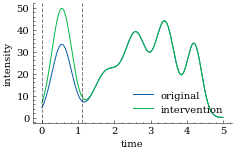

In [59]:
fig, ax = plt.subplots(figsize=(fig_height*fig_aspect,fig_height))
ax.plot(x, original(x), label = 'original')
ax.plot(x, intervention(x), label = 'intervention')
ax.set_xlabel('time', fontsize = 10)
ax.set_ylabel('intensity', fontsize = 10)
ax.axvline(x=begin, color = 'k', ls = '--', alpha = 0.5)
ax.axvline(x=end, color = 'k', ls = '--', alpha = 0.5)
ax.legend(loc='lower right', fontsize = 10)
ax.set_xticks(np.arange(0,T +1,1))
ax.set_yticks(np.arange(0,60,10))
# plt.savefig('{}/intensities1.pdf'.format(path), format = 'pdf', dpi = 900)

In [60]:
x = np.arange(begin, end, delta)
len(0.5 * (x[:-1] + x[1:]))

12

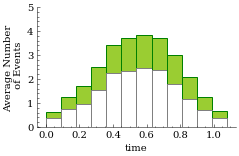

In [62]:
fig, ax = plt.subplots(figsize=(fig_height*fig_aspect,fig_height))
k = 0
weights = [0.25, 0.5, 0.25]
out_f = np.convolve(bin_numbers[k],np.array(weights)[::-1],'same')
out_o = np.convolve(original_bin_numbers[k],np.array(weights)[::-1],'same')
s = len(out_f)
xnew_bar = np.arange(begin, end, delta)
xnew_bar = 0.5 * (xnew_bar[:-1] + xnew_bar[1:])
for i in range(len(out_f)):
    a = np.abs(out_f[i]) # counterfactual
    b = np.abs(out_o[i]) # original
    if a > b:
        ax.bar(xnew_bar[i], a, label='cubic', width = delta, color = 'yellowgreen', edgecolor='green')
        ax.bar(xnew_bar[i], b, label='cubic', width = delta, color = 'white', edgecolor='grey')
    else:
        ax.bar(xnew_bar[i], b, label='cubic', width = delta, color = 'salmon', edgecolor='red')
        ax.bar(xnew_bar[i], a, label='cubic', width = delta, color = 'white', edgecolor='grey')
        
    
# ax.bar(xnew_bar, np.abs(f_cubic[2](xnew_bar)), label='cubic', width = (end - begin) / 17, color = 'yellowgreen')
# ax.bar(xnew_bar, np.abs(o_cubic[2](xnew_bar)), label='cubic', width = (end - begin) / 17, color = 'red')
ax.set_xlabel('time')
ax.set_ylabel('Average Number \n of Events')
ax.set_yticks(np.arange(0,6,1))
ax.set_xticks(np.arange(begin,end,0.2))
# plt.savefig('{}/groups1_{}.pdf'.format(path, k + 1), format = 'pdf', dpi = 900)